## Preparing training data

The first step is loading the examples. They are split in two main folders: vehicle and non-vehicle examples. Inside each, there are more folders that actually contain the files, so we use "glob" to read all the examples from their subfolders and label them.

We read the images with mpimg since ir reads the images in as RGB, which is the same thing that the video does.

In [1]:
import cv2
import glob
import matplotlib.image as mpimg
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# Load 
vehicles = []
nonvehicles = []

for fname in glob.glob('training_images\\vehicles\\*\\*.png'):
    vehicles.append(mpimg.imread(fname))

vehicles_labels = np.ones(len(vehicles))

for fname in glob.glob('training_images\\non-vehicles\\*\\*.png'):
    nonvehicles.append(mpimg.imread(fname))

nonvehicles_labels = np.zeros(len(nonvehicles))

Once we have all the examples loaded, we make sure that the data is in the expected range and that we have a balanced example set.

Maximum value of vehicle image 0.752941 and data type float32
Maximum value of non-vehicle image 0.811765 and data type float32
Number of vehicle examples 8792
Number of non-vehicle examples 8968


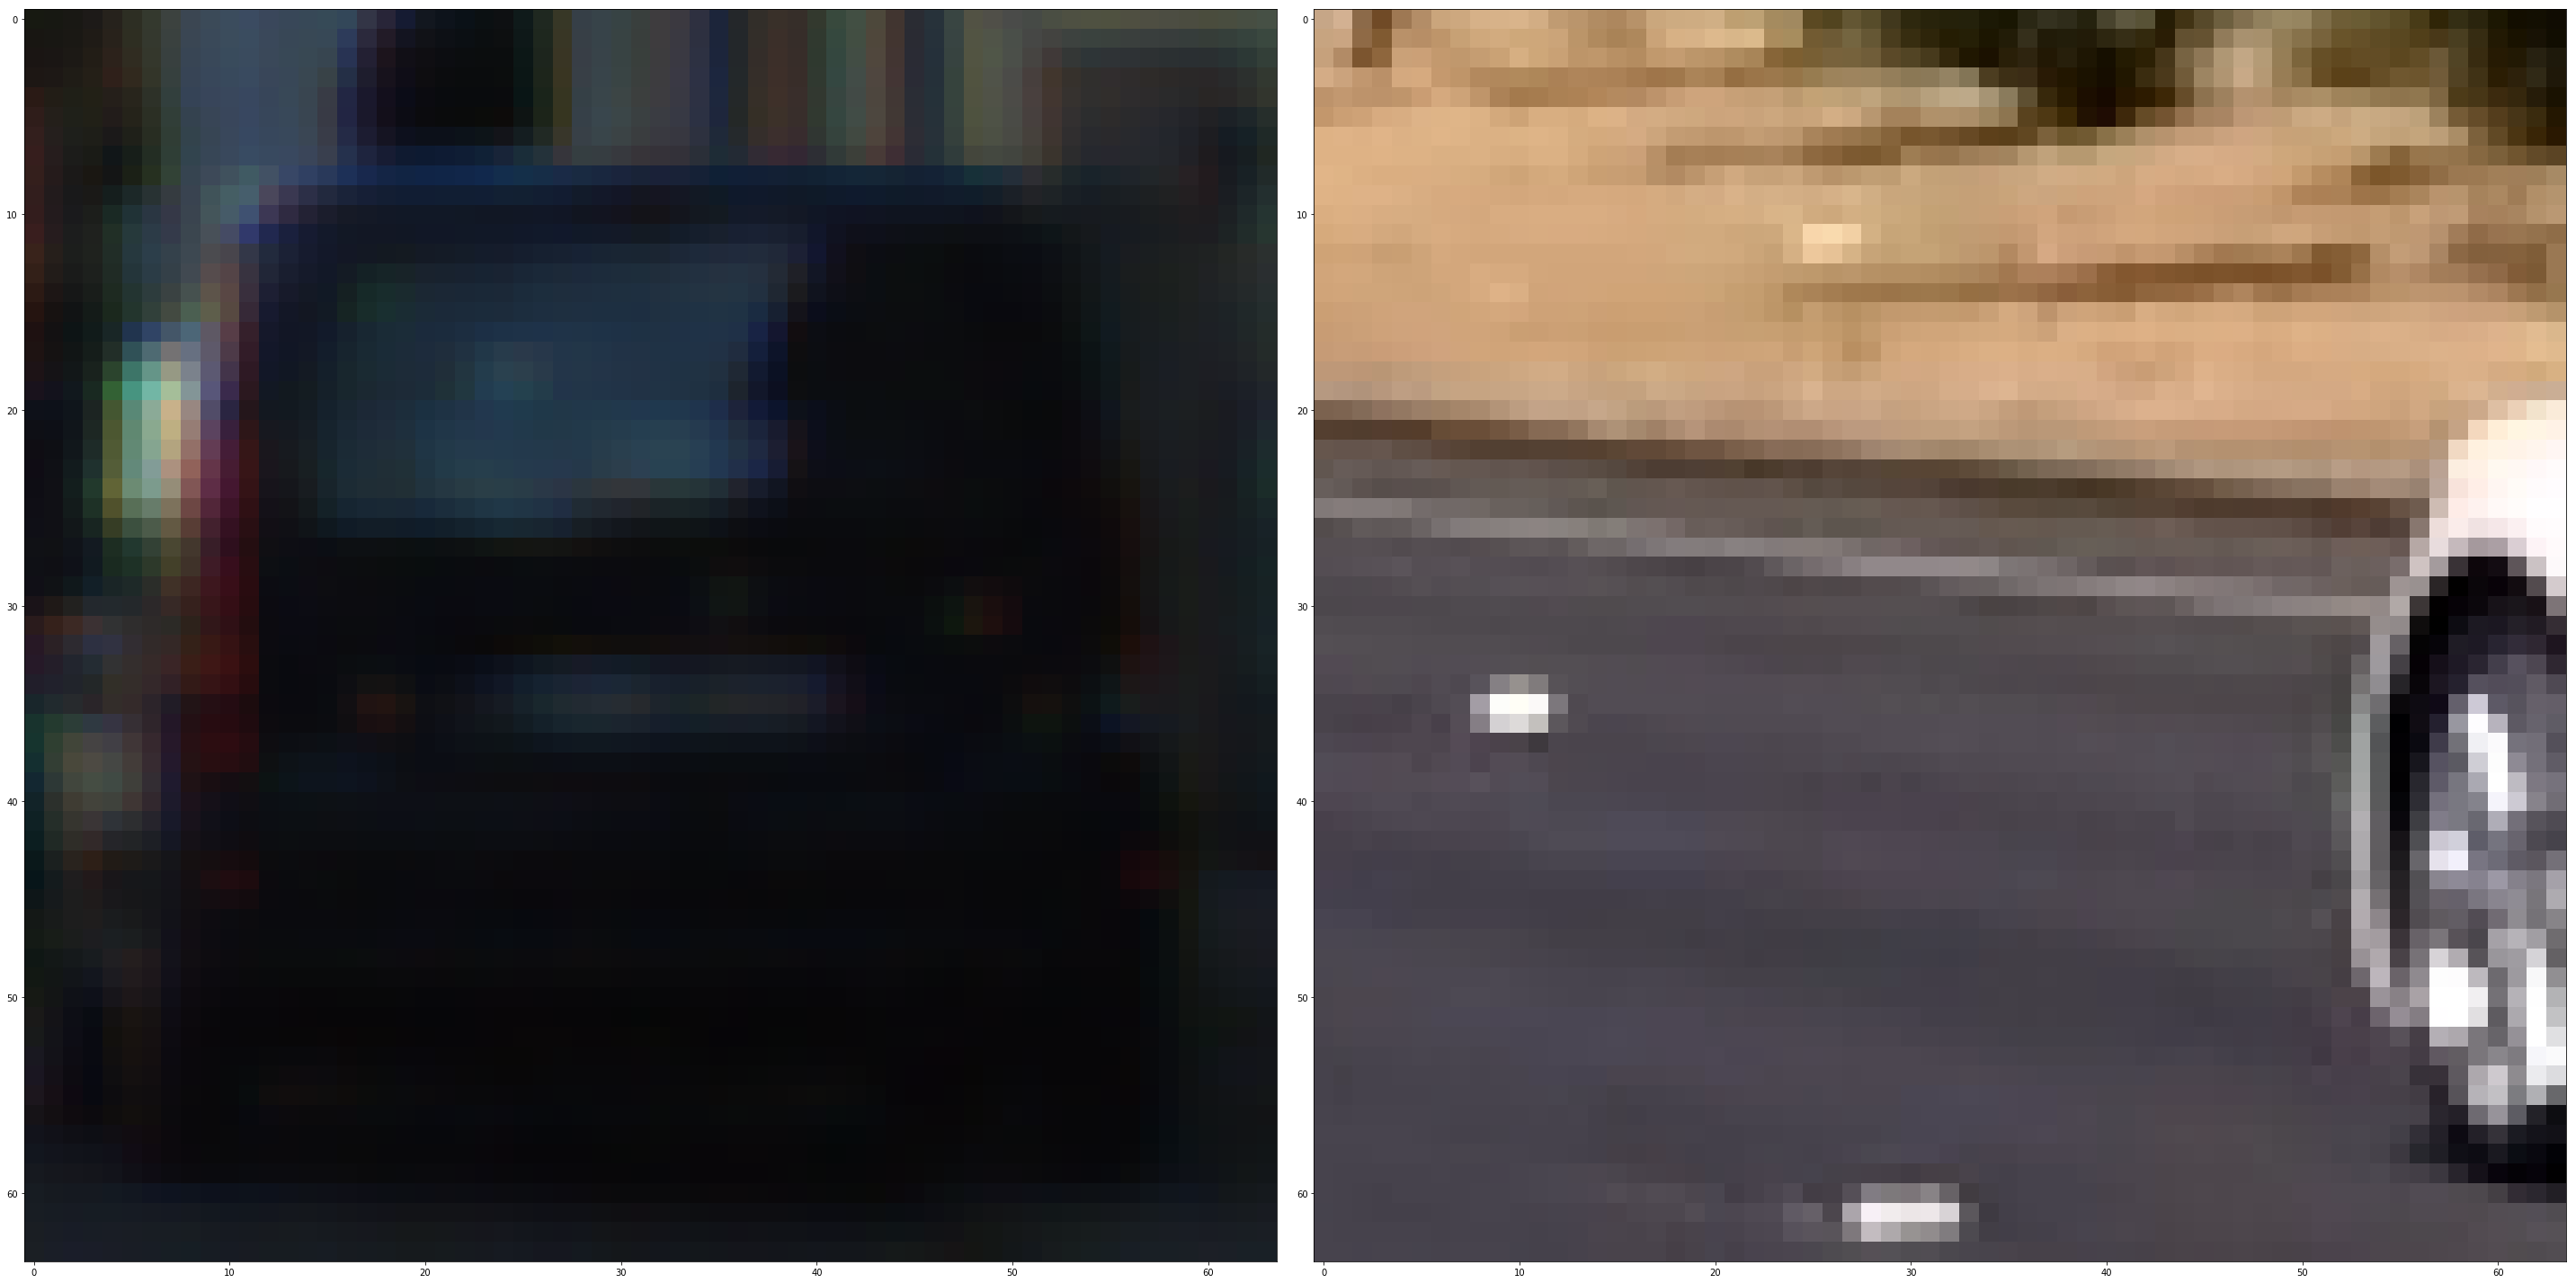

In [2]:
# Get information on the data
print("Maximum value of vehicle image", np.max(vehicles[0]), "and data type", vehicles[0].dtype)
print("Maximum value of non-vehicle image", np.max(nonvehicles[0]), "and data type", nonvehicles[0].dtype)
print("Number of vehicle examples", len(vehicles))
print("Number of non-vehicle examples", len(nonvehicles))

import matplotlib.pyplot as plt

f, ax = plt.subplots(1, 2, figsize=(40,80))
f.tight_layout()

ax[0].imshow(vehicles[np.random.randint(0, high=len(vehicles), size=1, dtype='l')[0]])
ax[1].imshow(nonvehicles[np.random.randint(0, high=len(nonvehicles), size=(1,), dtype='l')[0]])
    
plt.show()

Next, the separate arrays are merged and shuffled.

In [3]:
# Preparing the data
images = np.array(vehicles + nonvehicles)
labels = np.hstack((vehicles_labels, nonvehicles_labels))
images, labels = shuffle(images, labels, random_state=23)

## Extracting features from training data

In [4]:
from skimage.feature import hog

In [5]:
def to_uint8_image(img):
    if np.max(img) <= 1:
        return (img * 255).astype(np.uint8)
    else:
        return img
    
def convert_color(img, target_cspace, original_cspace='RGB'):
    if target_cspace != original_cspace:
        color_conversion = eval('cv2.COLOR_' + original_cspace + '2' + target_cspace) # TODO: Validate for safety
        image = cv2.cvtColor(img, color_conversion)
    else:
        # TODO: Make sure input is in the expected range and return accordingly
        image = img * 255 # Input image comes in 0-1 range but color conversion changes it to 0-255, so we emulate
    return image
        
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the RGB channels separately
    hist1 = np.histogram(img[:,:,0], bins=nbins, range=(0, 256))
    hist2 = np.histogram(img[:,:,1], bins=nbins, range=(0, 256))
    hist3 = np.histogram(img[:,:,2], bins=nbins, range=(0, 256))
    # Generating bin centers (the same for all colors since we use the same range and number of bins)
    bin_edges = hist1[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((hist1[0], hist2[0], hist3[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist1, hist2, hist3, bin_centers, hist_features

def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel()
    # Return the feature vector
    return features

def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        # Use skimage.hog() to get both features and a visualization
        features, hog_image = hog(img, orientations=orient,
                          pixels_per_cell=(pix_per_cell, pix_per_cell), 
                          cells_per_block=(cell_per_block, cell_per_block), 
                          transform_sqrt=False, 
                          visualise=True, feature_vector=feature_vec,
                          block_norm="L2-Hys")
        return features, hog_image
    else:      
        # Use skimage.hog() to get features only
        features = hog(img, orientations=orient,
                          pixels_per_cell=(pix_per_cell, pix_per_cell), 
                          cells_per_block=(cell_per_block, cell_per_block), 
                          transform_sqrt=False, 
                          visualise=False, feature_vector=feature_vec,
                          block_norm="L2-Hys")
        return features

In [6]:
length = 8
test_images = np.random.randint(0, high=len(images), size=(length,), dtype='l')

Rows: 8 , Columns: 4


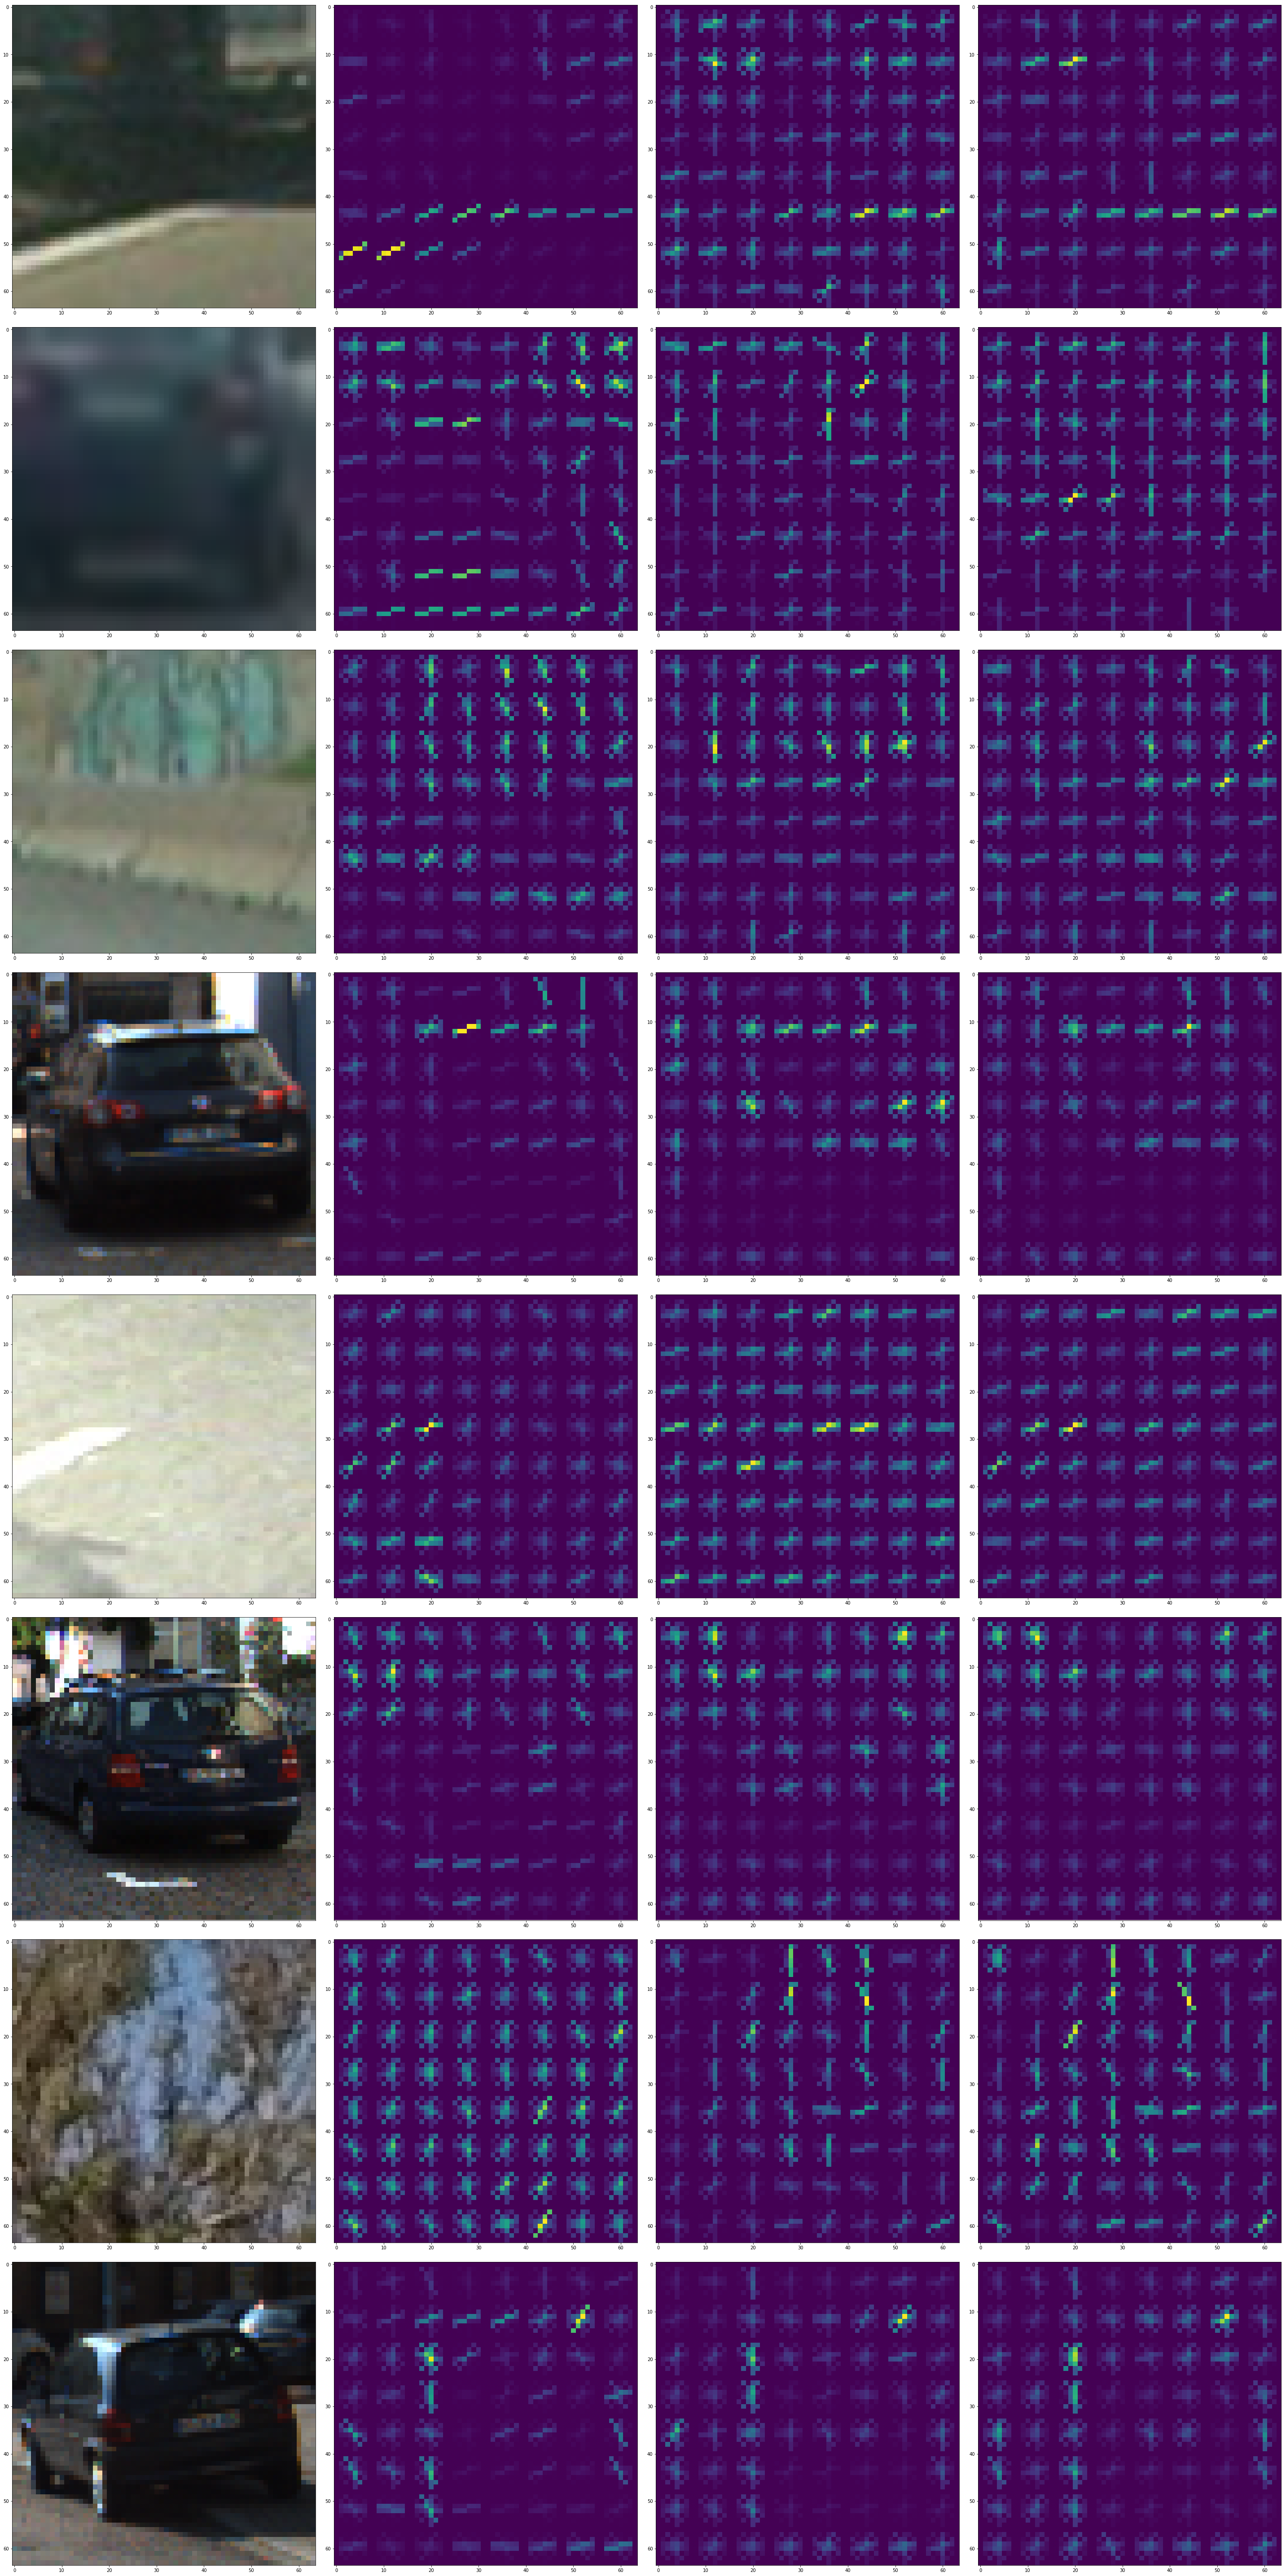

In [7]:
import matplotlib.pyplot as plt

columns = 4
rows = length
print("Rows:", rows, ", Columns:", columns)

f, ax = plt.subplots(rows, columns, figsize=(40,80))
#ax = [c for r in ax for c in r]
f.tight_layout()

orient=9
pix_per_cell=8
cell_per_block=2
#hog_channel=0

for i, idx in enumerate(test_images):
    ax[i][0].imshow(images[idx])
    image = convert_color(to_uint8_image(np.copy(images[idx])), 'YUV')
    _, draw_img = get_hog_features(image[:,:,0], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
    ax[i][1].imshow(draw_img)
    _, draw_img = get_hog_features(image[:,:,1], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
    ax[i][2].imshow(draw_img)
    _, draw_img = get_hog_features(image[:,:,2], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
    ax[i][3].imshow(draw_img)

plt.show()

In [8]:
from sklearn.preprocessing import StandardScaler

def extract_features(img, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256), orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    img = to_uint8_image(img)
    image1 = convert_color(img, cspace, original_cspace='RGB')
    #print("After second conversion", image2[0,0,:])
    # Apply bin_spatial() to get spatial color features
    spatial_features = bin_spatial(image1, spatial_size)
    # Apply color_hist() to get color histogram features
    color_features = color_hist(image1, hist_bins, hist_range)[4]
    # Now get HOG features
    if hog_channel == 'ALL':
        hog_features = []
        for channel in range(image1.shape[2]):
            hog_features.append(get_hog_features(image1[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
        hog_features = np.ravel(hog_features)
    else:
        hog_features = get_hog_features(image1[:,:,hog_channel], orient,
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
    # Append the new feature vector to the features list
    # Return list of feature vectors
    return np.concatenate([spatial_features, color_features, hog_features])

# Images is an RGB image in 0-1 float32
X = np.array([extract_features(x, cspace='YUV', spatial_size=(16, 16), hist_bins=64, pix_per_cell=pix_per_cell) for x in images]) 

In [9]:
X = X.astype(np.float64)

In [10]:
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

## Training classifier

First, the data is split into Train and Test sets.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(scaled_X, labels, test_size=0.2)

Next, we do a grid search on SVM parameters to find the best options. This is a time-consuming process that we will run on an AWS instance that has more computing power than our laptop.

Once the best set of parameters is found, we can apply them to our classifier.

In [12]:
import time
from sklearn.svm import SVC #, LinearSVC

# Define the Support Vector Classifier
svc = SVC(C=1, kernel='poly', gamma=0.1)
# Train the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train the SVM classifier...')

146.1 Seconds to train the SVM classifier...


In [13]:
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4)) # 0.9854

Test Accuracy of SVC =  0.9921


## Define vehicle search algorithm

In [14]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, cells_per_step, svc, 
              X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    img = to_uint8_image(img)
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch1 = convert_color(img_tosearch, 'YUV')
    if scale != 1:
        imshape = ctrans_tosearch1.shape
        ctrans_tosearch1 = cv2.resize(ctrans_tosearch1, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    ch = ctrans_tosearch1[:,:,0]

    # Define blocks and steps as above
    nxblocks = (ch.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    #cells_per_step = 2  # Define how many cells to step as a function parameter
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog = get_hog_features(ch, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    boxes = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_features = hog[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch1[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            color_features = color_hist(subimg, nbins=hist_bins)[4]

            # Scale features and make a prediction
            # Review http://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC.decision_function
            test_features = X_scaler.transform(np.hstack((spatial_features, color_features, hog_features)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            #confidence = svc.decision_function(test_features)
            
            #if test_prediction == 1 and confidence[0] > 2:
            if test_prediction == 1:
                #print(svc.decision_function(test_features))
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                box = ((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart))
                boxes.append(box)
                
    return boxes

## Test vehicle search

Rows: 2 , Columns: 4


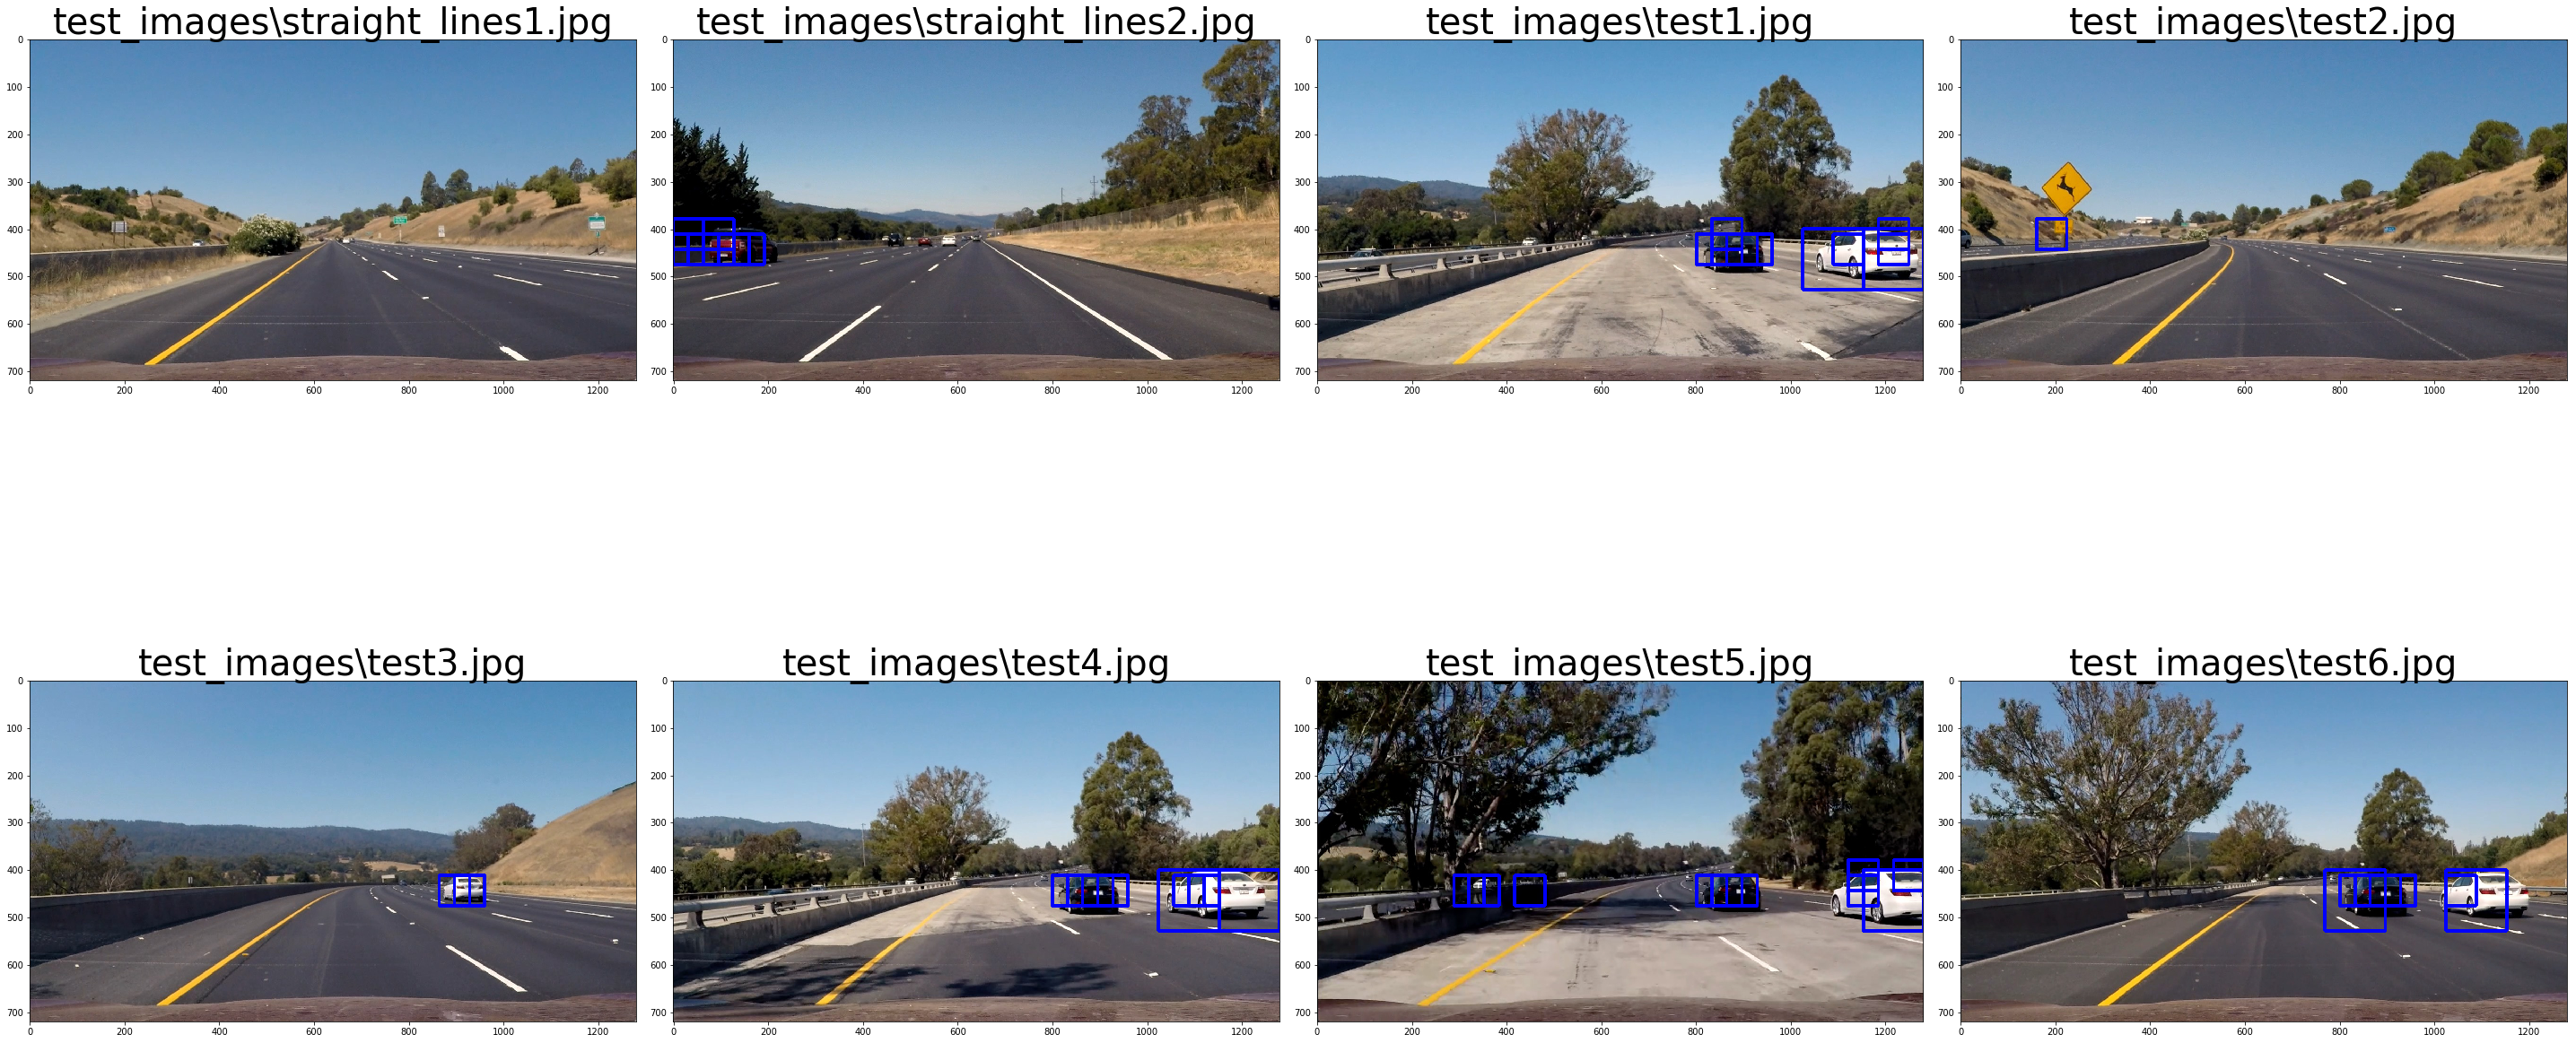

In [57]:
import math
import matplotlib.pyplot as plt
from multiprocessing.pool import ThreadPool # Use multithreading to speed things up

test_images = glob.glob('test_images\\*.jpg')
length = len(test_images)
columns = 4
rows = math.ceil(length/(columns*1.0))
print("Rows:", rows, ", Columns:", columns)
f, ax = plt.subplots(rows, columns, figsize=(40,20))
ax = [c for r in ax for c in r]
f.tight_layout()

for i, fname in enumerate(test_images):
    image = mpimg.imread(fname)
    
    params = [{
        'img':image, 'ystart':400, 'ystop':680, 'scale':3, 'cells_per_step':12, 'svc':svc, 
        'X_scaler':X_scaler, 'orient':9, 'pix_per_cell':8, 'cell_per_block':2, 'spatial_size':(16,16), 'hist_bins':64
    },{
        'img':image, 'ystart':400, 'ystop':600, 'scale':2, 'cells_per_step':8, 'svc':svc, 
        'X_scaler':X_scaler, 'orient':9, 'pix_per_cell':8, 'cell_per_block':2, 'spatial_size':(16,16), 'hist_bins':64
    },{
        'img':image, 'ystart':380, 'ystop':500, 'scale':1, 'cells_per_step':4, 'svc':svc, 
        'X_scaler':X_scaler, 'orient':9, 'pix_per_cell':8, 'cell_per_block':2, 'spatial_size':(16,16), 'hist_bins':64
    }]
    boxes = None
    with ThreadPool(processes=len(params)) as pool:
        results = [pool.apply_async(find_cars, kwds=p) for p in params]
        boxes = [item for sublist in [res.get() for res in results] for item in sublist]
    
    draw_img = np.copy(image)
    for box in boxes:
        cv2.rectangle(draw_img,box[0],box[1],(0,0,255),6)
        
    ax[i].set_title(fname, fontsize=40)
    ax[i].imshow(draw_img)

plt.show()

## Camera Calibration

We have images necessary to calibrate the camera used for the project video, so we do that in order to make our predictions more reliable and as part of the normal steps of the image feed pipeline.

In [21]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# Number of X and Y points in chessboard
nx = 9
ny = 6

# Arrays to hold data for calibration
objpoints = []
imgpoints = []

# Array with objectpoints
objp = np.zeros((nx*ny, 3), np.float32)
objp[:, :2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)

# Using range instead of glob to skip image 1 which we will use for validation
for fnum in range(2, 20):
    # Load image
    fname = 'camera_cal/calibration{}.jpg'.format(fnum)
    img = cv2.imread(fname)

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    found_corners, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    # If found, draw corners
    if found_corners == True:
        # TODO: Draw and display the corners
        #cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        #plt.imshow(img)
        imgpoints.append(corners)
        objpoints.append(objp)

calibration_ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1], None, None)

### Test  calibration

Where we load that first calibration image that doesn't have the last row of points (6th) visible to validate the calibration from the other 19 images. The result is somewhat there but not quite convincing... I still see some distortion in the first column.

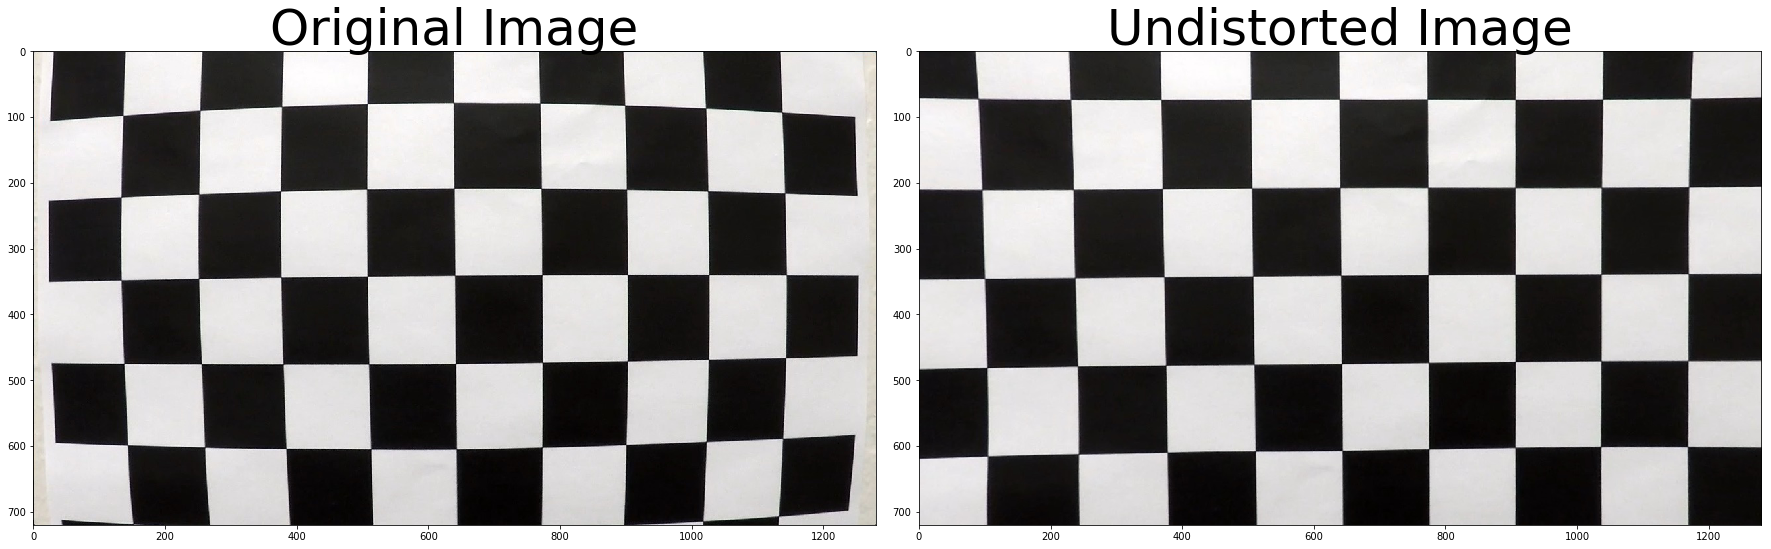

In [22]:
import matplotlib.image as mpimg

# Load image
fname = 'camera_cal/calibration1.jpg'
img = mpimg.imread(fname)

# Apply undistortion, with previously calculated values
undistorted = cv2.undistort(img, mtx, dist, None, mtx)

# Display result next to original
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


## Apply as is to video

We run the process on the video (the smaller test one) for a reference on how we are doing so far.

In [58]:
from multiprocessing.pool import ThreadPool # Use multithreading to speed things up
times = []
def process_image(image):
    # TODO: Get rid of globals
    global times
    undistorted = cv2.undistort(img, mtx, dist, None, mtx)

    params = [{
        'img':image, 'ystart':400, 'ystop':680, 'scale':3, 'cells_per_step':12, 'svc':svc, 
        'X_scaler':X_scaler, 'orient':9, 'pix_per_cell':8, 'cell_per_block':2, 'spatial_size':(16,16), 'hist_bins':64
    },{
        'img':image, 'ystart':400, 'ystop':600, 'scale':2, 'cells_per_step':8, 'svc':svc, 
        'X_scaler':X_scaler, 'orient':9, 'pix_per_cell':8, 'cell_per_block':2, 'spatial_size':(16,16), 'hist_bins':64
    },{
        'img':image, 'ystart':380, 'ystop':500, 'scale':1, 'cells_per_step':4, 'svc':svc, 
        'X_scaler':X_scaler, 'orient':9, 'pix_per_cell':8, 'cell_per_block':2, 'spatial_size':(16,16), 'hist_bins':64
    }]
    boxes = None
    with ThreadPool(processes=len(params)) as pool:
        results = [pool.apply_async(find_cars, kwds=p) for p in params]
        boxes = [item for sublist in [res.get() for res in results] for item in sublist]
    
    draw_img = np.copy(image)
    for box in boxes:
        cv2.rectangle(draw_img,box[0],box[1],(0,0,255),6)
    times.append(time.time())
    return draw_img

In [59]:
# Load the videoclip
from moviepy.editor import VideoFileClip
from IPython.display import HTML
output = 'test_video_out.mp4'
clip1 = VideoFileClip("test_video.mp4") #.subclip(31,32)

In [60]:
# Process the video frame by frame and save it
times.append(time.time())
try:
    output_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
    %time output_clip.write_videofile(output, audio=False)
finally:
    clip1.reader.close()
    clip1.audio.reader.close_proc()

[MoviePy] >>>> Building video test_video_out.mp4
[MoviePy] Writing video test_video_out.mp4


 97%|███████████████████████████████████████████████████████████████████████████████▉  | 38/39 [00:49<00:01,  1.33s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out.mp4 

Wall time: 52.7 s


In [61]:
# Display it in the notebook
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

The result shows promise, cars are identified correctly in each frame, although we get some false possitives, which we intend to weed out with the use of heatmaps. Now, how fast are we in processing? This obviously depends a bit on the hardware, but here is for reference on an i5 with 3.7GB of RAM running Windows 10 and a bunch of stuff running.

In [62]:
from functools import reduce
elapsed = np.array([times[i+1]-times[i] for i in range(len(times)-1)])
print("Mean time between frames processing", np.mean(elapsed))
print("Maximum elapsed time", np.max(elapsed))

Mean time between frames processing 1.31904531137
Maximum elapsed time 1.63463711739


## Redefine vehicle search with time series modification

In [63]:
# From the lesson
def add_heat(heatmap, bbox_list):
    #print(len(bbox_list))
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

In [86]:
from scipy.ndimage.measurements import label
from multiprocessing.pool import ThreadPool
times = []
heatmap_list = [] # TODO: Maybe change to 'collections.deque' (https://stackoverflow.com/questions/2150108/efficient-way-to-shift-a-list-in-python)
def process_image_w_heatmaps(image):
    # TODO: Get rid of globals
    #global times
    global heatmap_list
    empty = np.zeros_like(img).astype(np.uint8)
    if len(heatmap_list) == 0:
        heatmap_list.extend([empty, empty, empty, empty, empty, empty]) # Keep a three frame memory
        
    undistorted = cv2.undistort(img, mtx, dist, None, mtx)
    #(img, ystart, ystop, scale, cells_per_step, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    params = [{
        'img':image, 'ystart':400, 'ystop':680, 'scale':3, 'cells_per_step':12, 'svc':svc, 
        'X_scaler':X_scaler, 'orient':9, 'pix_per_cell':8, 'cell_per_block':2, 'spatial_size':(16,16), 'hist_bins':64
    },{
        'img':image, 'ystart':400, 'ystop':600, 'scale':2, 'cells_per_step':8, 'svc':svc, 
        'X_scaler':X_scaler, 'orient':9, 'pix_per_cell':8, 'cell_per_block':2, 'spatial_size':(16,16), 'hist_bins':64
    },{
        'img':image, 'ystart':380, 'ystop':500, 'scale':1, 'cells_per_step':4, 'svc':svc, 
        'X_scaler':X_scaler, 'orient':9, 'pix_per_cell':8, 'cell_per_block':2, 'spatial_size':(16,16), 'hist_bins':64
    }]
    boxes = None
    with ThreadPool(processes=len(params)) as pool:
        results = [pool.apply_async(find_cars, kwds=p) for p in params]
        boxes = [item for sublist in [res.get() for res in results] for item in sublist]
    
    # Add an empty heatmap for this frame
    heatmap_list.append(empty)
    
    # Add the heat detected in this frame
    heatmap_list = [add_heat(x, boxes) for x in heatmap_list]
    # Use the oldest heatmap to label and draw boxes
    heat = apply_threshold(heatmap_list[0],7)
    labels = label(heat)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    # Dump oldest heatmap
    heatmap_list = heatmap_list[1:]
    times.append(time.time())
    return draw_img #np.clip(heatmap_list[0], 0, 255) #draw_img

In [87]:
# Load the videoclip
from moviepy.editor import VideoFileClip
from IPython.display import HTML
output = 'test_video_out_2.mp4'
clip1 = VideoFileClip("test_video.mp4") #.subclip(31,32)

In [88]:
times = []
times.append(time.time())
try:
    output_clip = clip1.fl_image(process_image_w_heatmaps) #NOTE: this function expects color images!!
    %time output_clip.write_videofile(output, audio=False)
finally:
    clip1.reader.close()
    clip1.audio.reader.close_proc()

[MoviePy] >>>> Building video test_video_out_2.mp4
[MoviePy] Writing video test_video_out_2.mp4



 97%|███████████████████████████████████████████████████████████████████████████████▉  | 38/39 [00:55<00:01,  1.47s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out_2.mp4 

Wall time: 57.5 s


In [89]:
# Display it in the notebook
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

In [90]:
from functools import reduce
elapsed = np.array([times[i+1]-times[i] for i in range(len(times)-1)])
print("Mean time between frames processing", np.mean(elapsed))
print("Maximum elapsed time", np.max(elapsed))

Mean time between frames processing 1.46186260077
Maximum elapsed time 1.6997423172


In [91]:
# Load the videoclip
from moviepy.editor import VideoFileClip
from IPython.display import HTML
output = 'project_video_out.mp4'
clip1 = VideoFileClip("project_video.mp4") #.subclip(22,28)

In [92]:
times = []
times.append(time.time())
try:
    output_clip = clip1.fl_image(process_image_w_heatmaps) # Without heatmap
    %time output_clip.write_videofile(output, audio=False)
finally:
    clip1.reader.close()
    clip1.audio.reader.close_proc()

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [30:37<00:01,  1.46s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

Wall time: 30min 40s


In [93]:
# Display it in the notebook
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

In [94]:
#import winsound
elapsed = np.array([times[i+1]-times[i] for i in range(len(times)-1)])
print("Mean time between frames processing", np.mean(elapsed))
print("Maximum elapsed time", np.max(elapsed))
#winsound.Beep(440, 1000)

Mean time between frames processing 1.45887148617
Maximum elapsed time 1.8578877449


In [95]:
import winsound
winsound.Beep(600, 1000)

Now we display the heatmap only, for educational purposes.

In [96]:
from scipy.ndimage.measurements import label
from multiprocessing.pool import ThreadPool
times = []
heatmap_list = [] # TODO: Maybe change to 'collections.deque' (https://stackoverflow.com/questions/2150108/efficient-way-to-shift-a-list-in-python)
def process_image_for_heatmaps(image):
    # TODO: Get rid of globals
    #global times
    global heatmap_list
    empty = np.zeros_like(img).astype(np.uint8)
    if len(heatmap_list) == 0:
        heatmap_list.extend([empty, empty, empty, empty, empty, empty]) # Keep a three frame memory
        
    undistorted = cv2.undistort(img, mtx, dist, None, mtx)
    #(img, ystart, ystop, scale, cells_per_step, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    params = [{
        'img':image, 'ystart':400, 'ystop':680, 'scale':3, 'cells_per_step':12, 'svc':svc, 
        'X_scaler':X_scaler, 'orient':9, 'pix_per_cell':8, 'cell_per_block':2, 'spatial_size':(16,16), 'hist_bins':64
    },{
        'img':image, 'ystart':400, 'ystop':600, 'scale':2, 'cells_per_step':8, 'svc':svc, 
        'X_scaler':X_scaler, 'orient':9, 'pix_per_cell':8, 'cell_per_block':2, 'spatial_size':(16,16), 'hist_bins':64
    },{
        'img':image, 'ystart':380, 'ystop':500, 'scale':1, 'cells_per_step':4, 'svc':svc, 
        'X_scaler':X_scaler, 'orient':9, 'pix_per_cell':8, 'cell_per_block':2, 'spatial_size':(16,16), 'hist_bins':64
    }]
    boxes = None
    with ThreadPool(processes=len(params)) as pool:
        results = [pool.apply_async(find_cars, kwds=p) for p in params]
        boxes = [item for sublist in [res.get() for res in results] for item in sublist]
    
    # Add an empty heatmap for this frame
    heatmap_list.append(empty)
    
    # Add the heat detected in this frame
    heatmap_list = [add_heat(x, boxes) for x in heatmap_list]
    # Use the oldest heatmap to label and draw boxes
    heat = apply_threshold(heatmap_list[0],7)
    
    # Dump oldest heatmap
    heatmap_list = heatmap_list[1:]
    times.append(time.time())
    return np.clip(heat, 0, 255)

In [97]:
# Load the videoclip
from moviepy.editor import VideoFileClip
from IPython.display import HTML
output = 'heatmap_video_out.mp4'
clip1 = VideoFileClip("project_video.mp4") #.subclip(31,32)

In [98]:
times = []
times.append(time.time())
try:
    output_clip = clip1.fl_image(process_image_for_heatmaps) # Without heatmap
    %time output_clip.write_videofile(output, audio=False)
finally:
    clip1.reader.close()
    clip1.audio.reader.close_proc()

[MoviePy] >>>> Building video heatmap_video_out.mp4
[MoviePy] Writing video heatmap_video_out.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [27:17<00:01,  1.24s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: heatmap_video_out.mp4 

Wall time: 27min 17s


In [99]:
# Display it in the notebook
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

In [100]:
elapsed = np.array([times[i+1]-times[i] for i in range(len(times)-1)])
print("Mean time between frames processing", np.mean(elapsed))
print("Maximum elapsed time", np.max(elapsed))
import winsound
winsound.Beep(600, 1000)

Mean time between frames processing 1.29941173568
Maximum elapsed time 1.82008886337


In [124]:
from scipy.ndimage.measurements import label
from multiprocessing.pool import ThreadPool
times = []
heatmap_list = [] # TODO: Maybe change to 'collections.deque' (https://stackoverflow.com/questions/2150108/efficient-way-to-shift-a-list-in-python)
def process_image_for_labels(image):
    # TODO: Get rid of globals
    #global times
    global heatmap_list
    empty = np.zeros_like(img).astype(np.uint8)
    if len(heatmap_list) == 0:
        heatmap_list.extend([empty, empty, empty, empty, empty, empty]) # Keep a three frame memory
        
    undistorted = cv2.undistort(img, mtx, dist, None, mtx)
    #(img, ystart, ystop, scale, cells_per_step, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    params = [{
        'img':image, 'ystart':400, 'ystop':680, 'scale':3, 'cells_per_step':12, 'svc':svc, 
        'X_scaler':X_scaler, 'orient':9, 'pix_per_cell':8, 'cell_per_block':2, 'spatial_size':(16,16), 'hist_bins':64
    },{
        'img':image, 'ystart':400, 'ystop':600, 'scale':2, 'cells_per_step':8, 'svc':svc, 
        'X_scaler':X_scaler, 'orient':9, 'pix_per_cell':8, 'cell_per_block':2, 'spatial_size':(16,16), 'hist_bins':64
    },{
        'img':image, 'ystart':380, 'ystop':500, 'scale':1, 'cells_per_step':4, 'svc':svc, 
        'X_scaler':X_scaler, 'orient':9, 'pix_per_cell':8, 'cell_per_block':2, 'spatial_size':(16,16), 'hist_bins':64
    }]
    boxes = None
    with ThreadPool(processes=len(params)) as pool:
        results = [pool.apply_async(find_cars, kwds=p) for p in params]
        boxes = [item for sublist in [res.get() for res in results] for item in sublist]
    
    # Add an empty heatmap for this frame
    heatmap_list.append(empty)
    
    # Add the heat detected in this frame
    heatmap_list = [add_heat(x, boxes) for x in heatmap_list]
    # Use the oldest heatmap to label and draw boxes
    heat = apply_threshold(heatmap_list[0],7)
    labels = label(heat)
    # Dump oldest heatmap
    heatmap_list = heatmap_list[1:]
    times.append(time.time())
    return labels[0]

In [125]:
# Load the videoclip
from moviepy.editor import VideoFileClip
from IPython.display import HTML
output = 'labelled_video_out.mp4'
clip1 = VideoFileClip("project_video.mp4") #.subclip(31,32)

In [126]:
times = []
times.append(time.time())
try:
    output_clip = clip1.fl_image(process_image_for_labels) # Without heatmap
    %time output_clip.write_videofile(output, audio=False)
finally:
    clip1.reader.close()
    clip1.audio.reader.close_proc()

[MoviePy] >>>> Building video labelled_video_out.mp4
[MoviePy] Writing video labelled_video_out.mp4



100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [29:48<00:01,  1.33s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: labelled_video_out.mp4 

Wall time: 29min 48s


In [127]:
# Display it in the notebook
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

In [128]:
elapsed = np.array([times[i+1]-times[i] for i in range(len(times)-1)])
print("Mean time between frames processing", np.mean(elapsed))
print("Maximum elapsed time", np.max(elapsed))
import winsound
winsound.Beep(600, 1000)

Mean time between frames processing 1.42009028851
Maximum elapsed time 2.38959860802


In [137]:
try:
    clip1 = VideoFileClip("project_video.mp4") #.subclip(31,32)
    clip2 = VideoFileClip("heatmap_video_out.mp4") #.subclip(31,32)
    clip3 = VideoFileClip("labelled_video_out.mp4") #.subclip(31,32)
    clip4 = VideoFileClip("project_video_out.mp4") #.subclip(31,32)
    frames = np.random.randint(0, high=clip1.duration*100, size=6, dtype='l')
    examples = [(clip1.get_frame(frame/100), clip2.get_frame(frame/100), clip3.get_frame(frame/100), clip4.get_frame(frame/100)) 
                for frame in frames]
finally:
    clip1.reader.close()
    clip1.audio.reader.close_proc()
    clip2.reader.close()
    clip3.reader.close()
    clip4.reader.close()

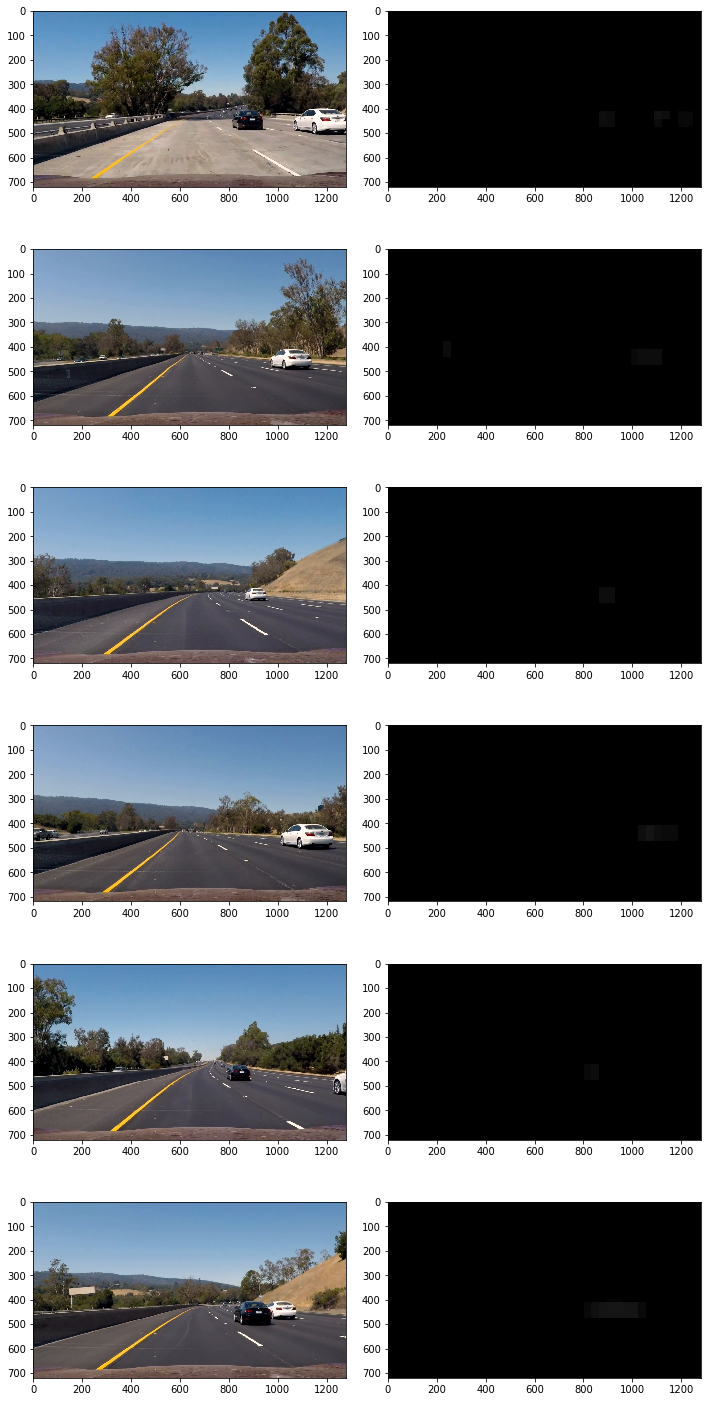

In [138]:
import matplotlib.pyplot as plt

f, ax = plt.subplots(len(examples), 2, figsize=(10,20))
f.tight_layout()

for i, example in enumerate(examples):
    ax[i][0].imshow(example[0])
    ax[i][1].imshow(example[1])
plt.show()

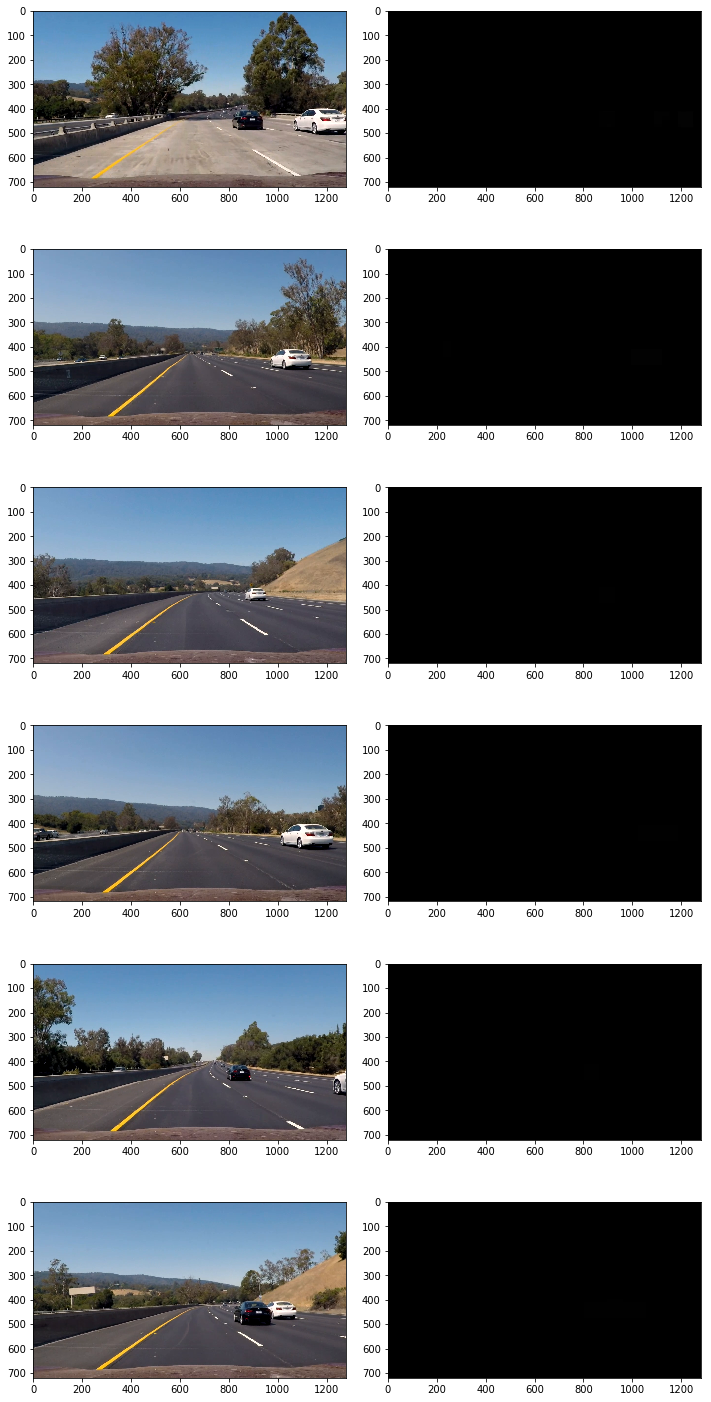

In [139]:
import matplotlib.pyplot as plt

f, ax = plt.subplots(len(examples), 2, figsize=(10,20))
f.tight_layout()

for i, example in enumerate(examples):
    ax[i][0].imshow(example[0])
    ax[i][1].imshow(example[2])
plt.show()

In [140]:
import matplotlib.pyplot as plt

f, ax = plt.subplots(len(examples), 2, figsize=(10,20))
f.tight_layout()

for i, example in enumerate(examples):
    ax[i][0].imshow(example[0])
    ax[i][1].imshow(example[3])
plt.show()